In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
lattice_file = shift.get_6dsim_dir()\
                    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt")
lattice_df = lattice.read_lattice_file(lattice_file)

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


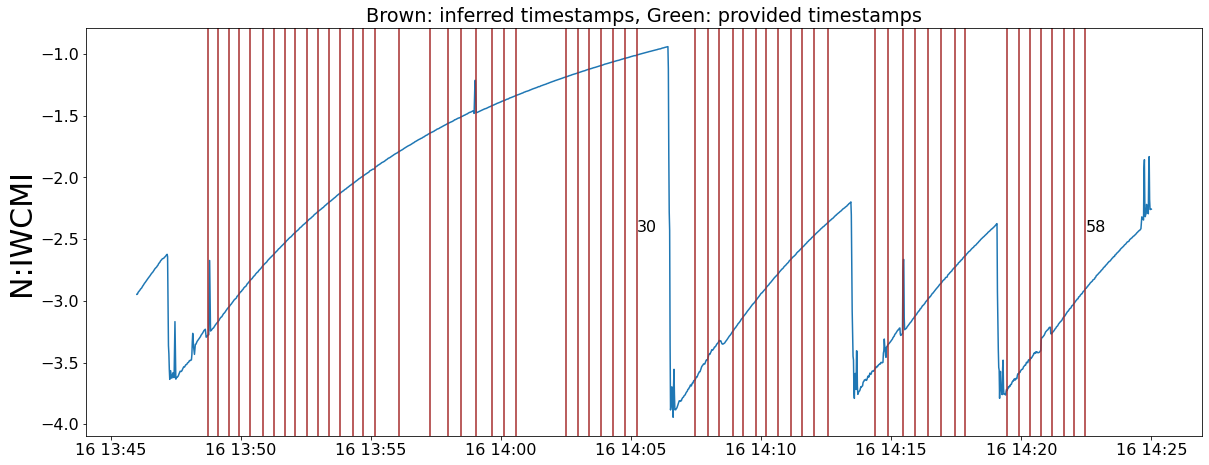

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:160: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/home/ilobach/fur/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [2]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [3]:
rdt = res_df_ROUND['real_datetime']
time_intervals = [(rdt[0], rdt[30]), (rdt[31], rdt[42]), (rdt[43], rdt[50]), (rdt[51], rdt[58])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 13:48:45'), Timestamp('2020-03-16 14:05:13')),
 (Timestamp('2020-03-16 14:07:27'), Timestamp('2020-03-16 14:12:34')),
 (Timestamp('2020-03-16 14:14:23'), Timestamp('2020-03-16 14:17:51')),
 (Timestamp('2020-03-16 14:19:26'), Timestamp('2020-03-16 14:22:28'))]

### removing two outliers in ROUND data:

In [4]:
outliers_ROUND = ['RefCurve_2020-03-16_61_135841.Wfm.bin', 'RefCurve_2020-03-16_86_141506.Wfm.bin']
res_df_ROUND = res_df_ROUND[~res_df_ROUND['waveform_file'].isin(outliers_ROUND)]

In [5]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

# Loosses in the long cable cna be accounted for here by a factor `losses`

In [6]:
losses = 1.0
sum_channel_to_photoelectrons =\
    1/losses*get_from_config('sum_channel_to_photoelectrons')
new_meas_photons_per_electron =\
    1/losses*get_from_config("Measured_photons_per_electron")
new_meas_photons_per_electron

0.008820875499988542

In [7]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [8]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [9]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [10]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

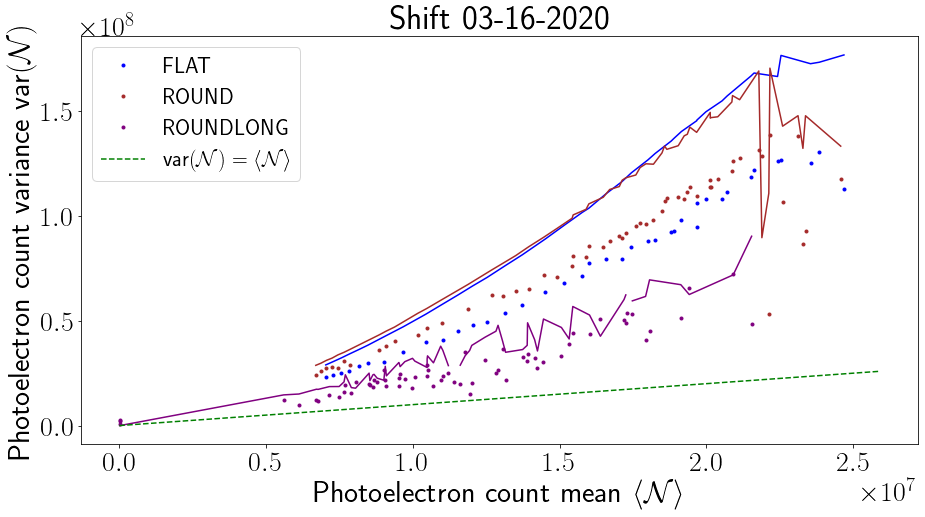

In [11]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

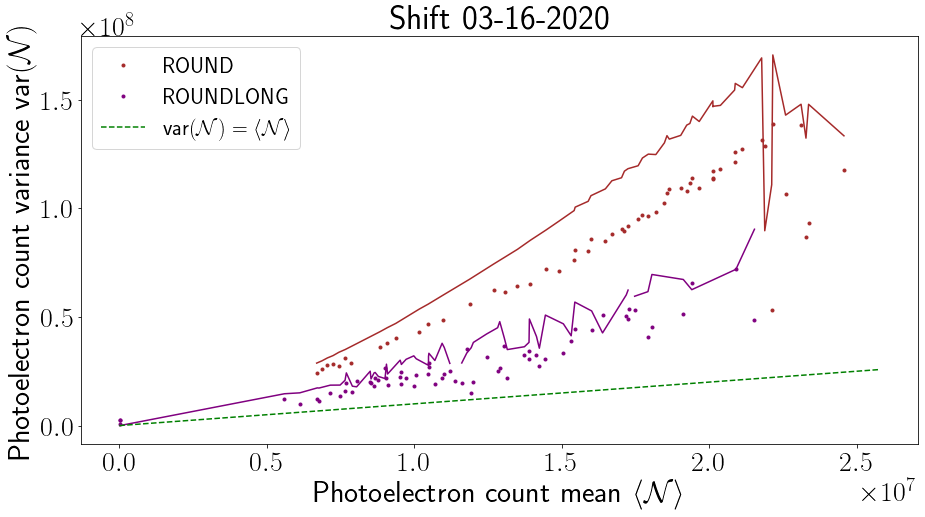

In [12]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [13]:
# acnet_df_ROUND_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_ROUND
# )

In [14]:
# acnet_df_ROUND_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'))

In [15]:
acnet_df_ROUND_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_ROUND_with_bunch_sizes_in_time_intervals = acnet_df_ROUND_with_bunch_sizes[acnet_df_ROUND_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

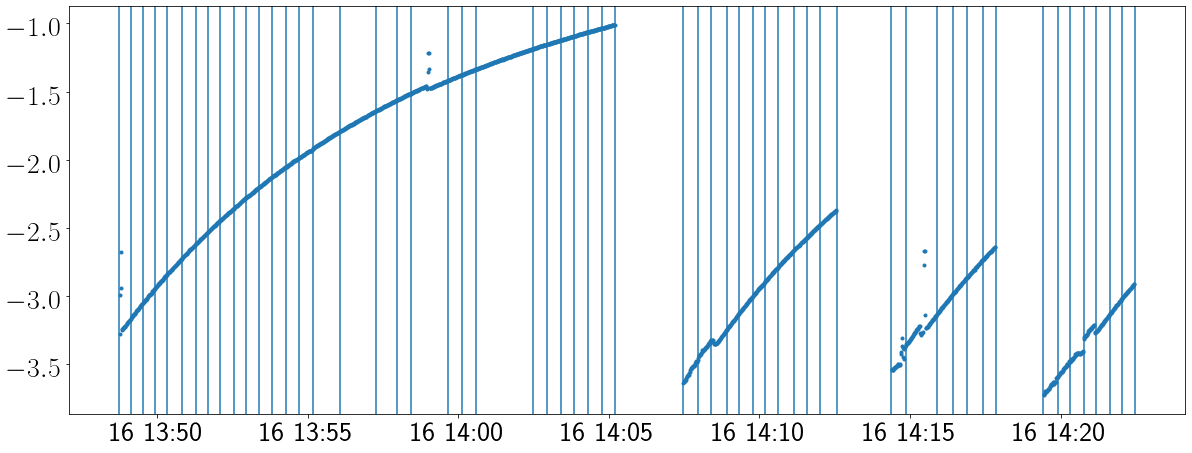

In [16]:
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

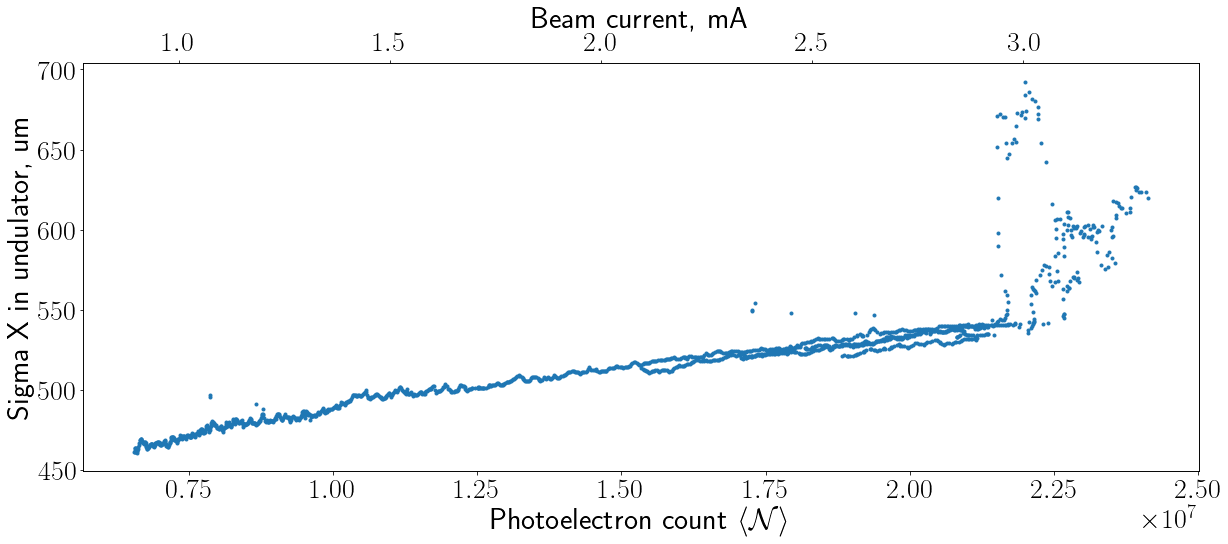

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

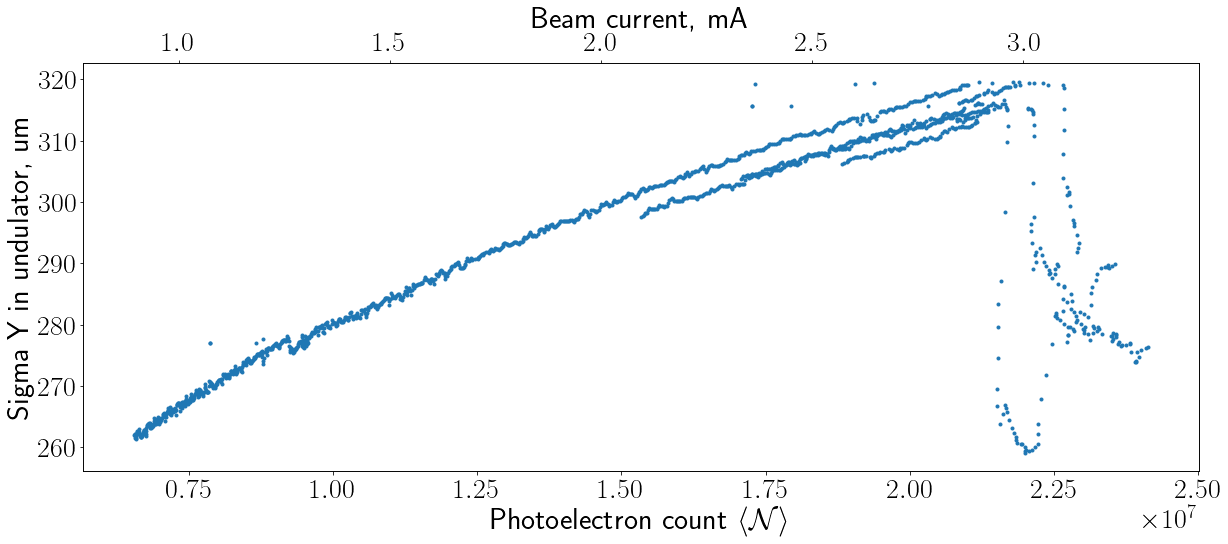

In [18]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [19]:
first_injection = acnet_df_ROUND_with_bunch_sizes_in_time_intervals[acnet_df_ROUND_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
df = first_injection


In [20]:
def get_ex_ey_vals(row):
    cameras_df = lattice.get_cameras_df(
                            lattice_df,
                            row[lattice.acnet_devices_X].values,
                            row[lattice.acnet_devices_Y].values)
    es = lattice.get_e_um_X_dict(cameras_df, row["dp/p"])
    eys = lattice.get_e_um_Y_dict(cameras_df)
    es.update(eys)
    return es 
ex_ey_by_camera_df = first_injection.apply(
        get_ex_ey_vals, axis=1, result_type='expand')
first_injection = pd.concat([first_injection, ex_ey_by_camera_df], axis=1)

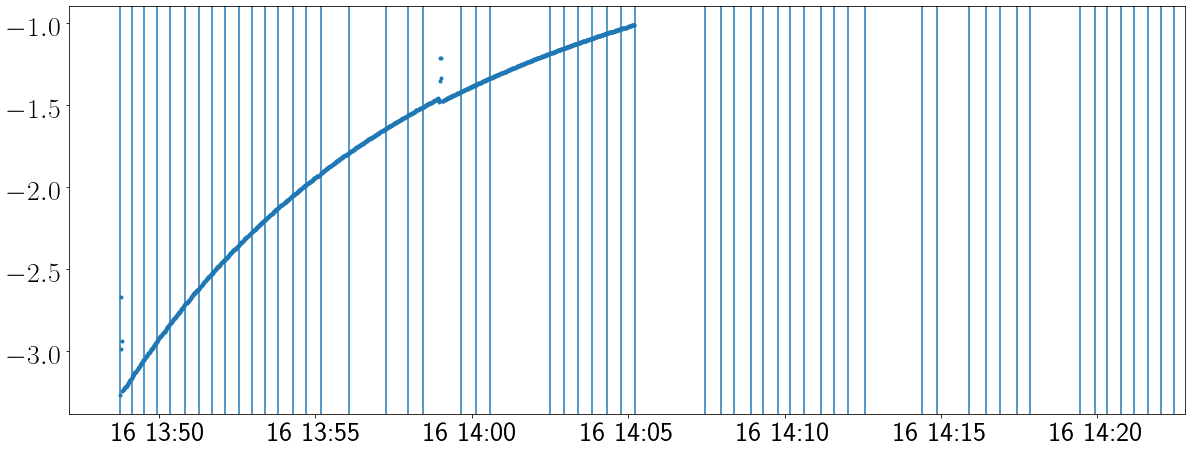

In [21]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

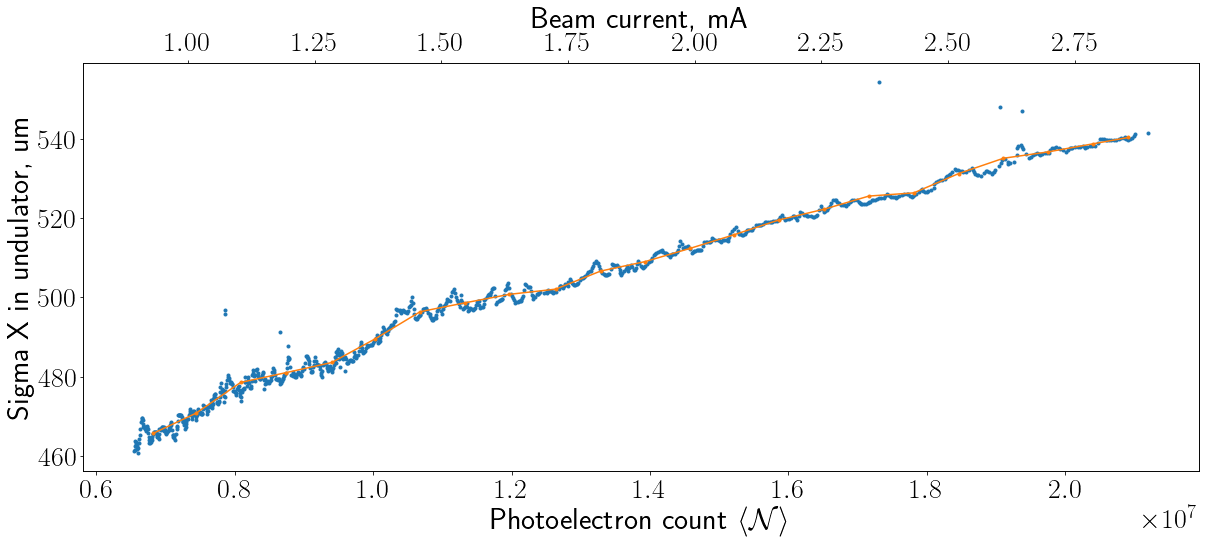

In [22]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save = pd.DataFrame(
    {"N": -df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
     "Sigma_um_X": df['Sigma_um_X']
    })
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [23]:
sx_err_stat

2.02370910686093

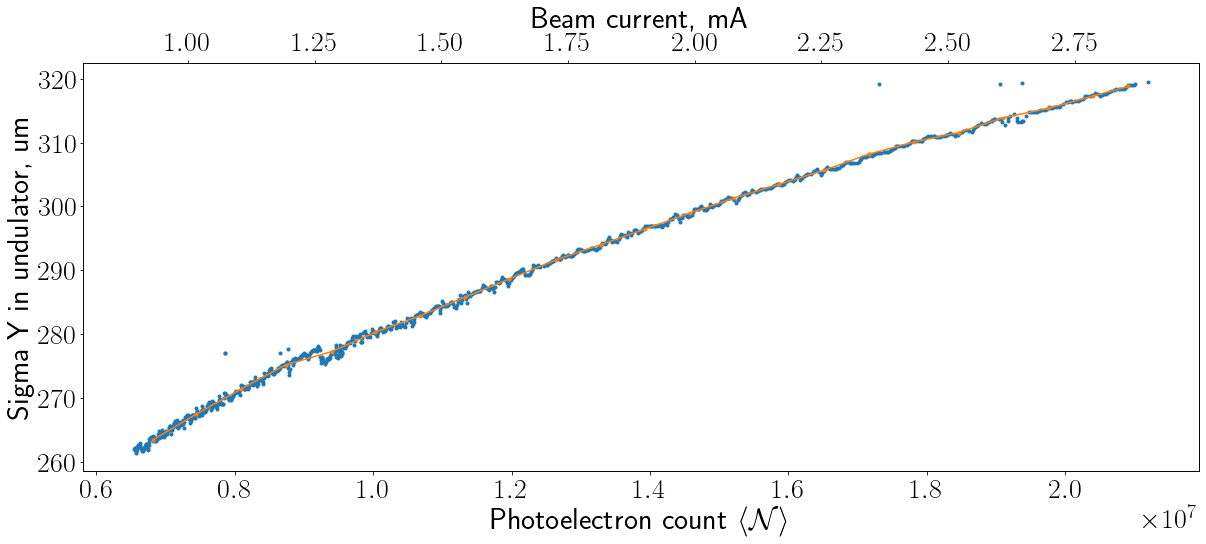

In [24]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save["Sigma_um_Y"] = df['Sigma_um_Y']
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [25]:
sy_err_stat

0.6831758341120098

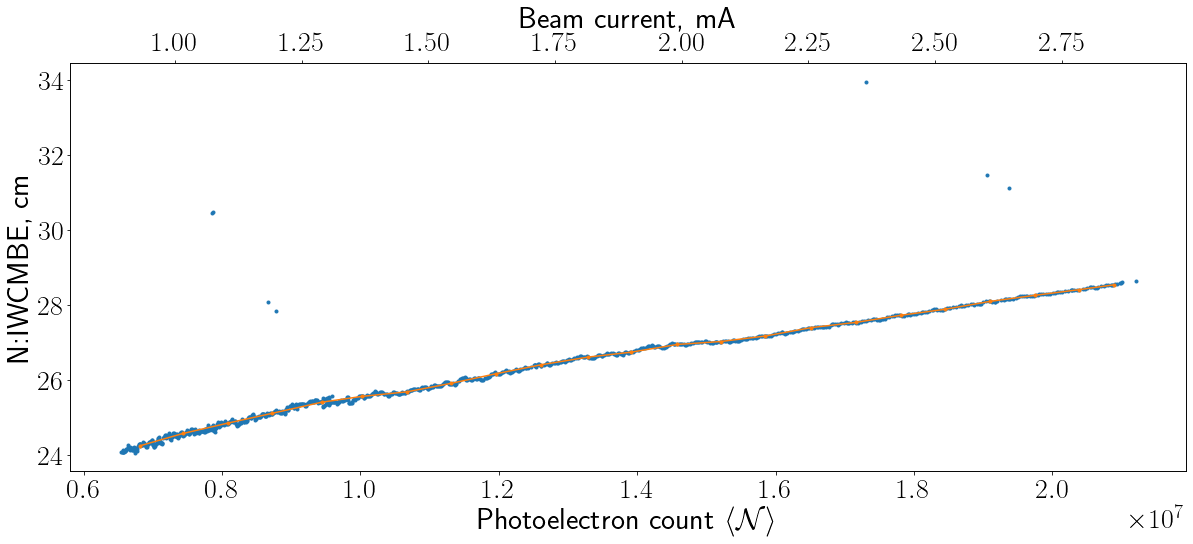

In [26]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_um'] = 1e4*df['N:IWCMBE'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [27]:
sz_err_stat

0.09119185892226393

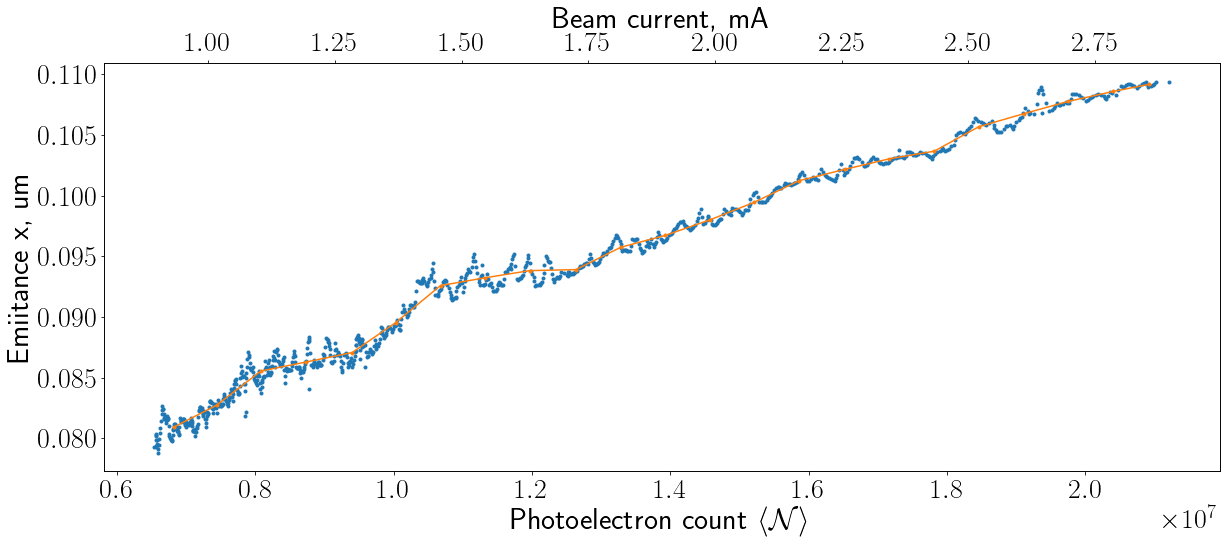

In [28]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ex_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance x, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ex_um'] = df['ex_um']
ex_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ex_um'], bounds_error=False, fill_value="extrapolate")
ex_interp = ex_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ex_err_stat = np.std(first_injection['ex_um'].values-ex_interp)
ax.plot(photoel, df['ex_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

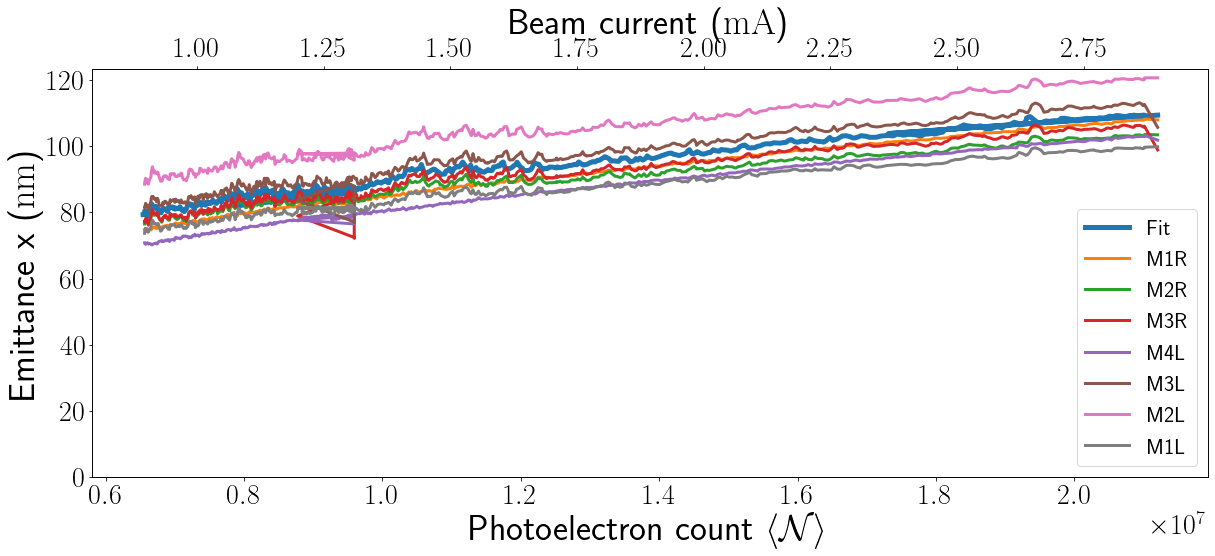

In [29]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, 1000*df['ex_um'],'-', linewidth=5 , label='Fit')
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_X_'+cam],
            linestyle='-', linewidth=3, label=cam)
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance x (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [30]:
camsx = ['e_um_X_'+cam for cam in lattice.active_cameras]
def get_x_errors_one_row(row):
    exfit = row['ex_um']
    excams = row[camsx]
    higher = excams[excams>exfit]
    lower = excams[excams<exfit]
    errhigher = np.sqrt(np.mean((higher-exfit)**2))
    errlower = np.sqrt(np.mean((lower-exfit)**2))
    return {'ex_err_high':errhigher, 'ex_err_low':errlower}
ex_errors = df.apply(get_x_errors_one_row, axis=1, result_type='expand')
ex_err_plus, ex_err_minus = 1000*ex_errors.mean()
ex_err_plus, ex_err_minus

(7.617578064176614, 5.735226390973864)

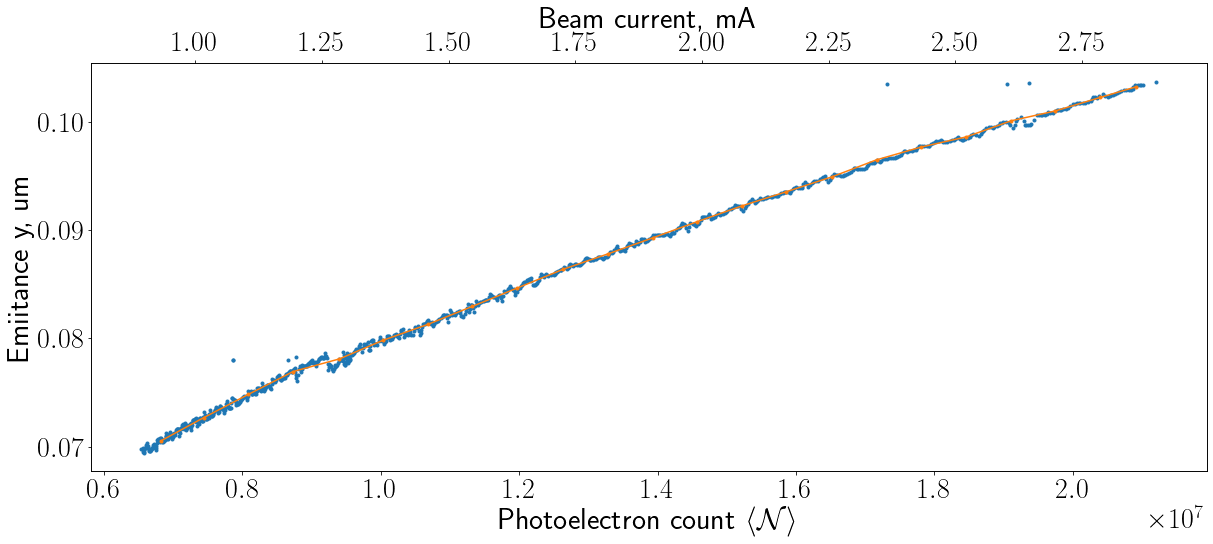

In [31]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ey_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance y, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ey_um'] = df['ey_um']
ey_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ey_um'], bounds_error=False, fill_value="extrapolate")
ey_interp = ey_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ey_err_stat = np.std(first_injection['ey_um'].values-ey_interp)
ax.plot(photoel, df['ey_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

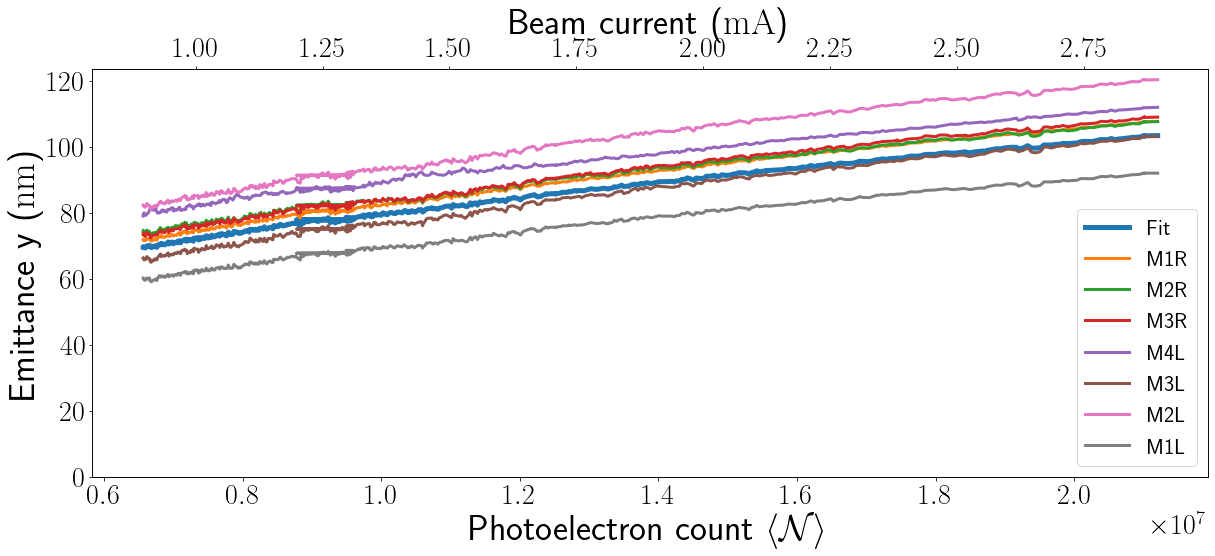

In [32]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel.rolling(4).max(), 1000*df['ey_um'],'-', linewidth=5 , label='Fit')
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_Y_'+cam],
            linestyle='-', linewidth=3, label=cam)
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance y (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [33]:
camsy = ['e_um_Y_'+cam for cam in lattice.active_cameras]
def get_y_errors_one_row(row):
    eyfit = row['ey_um']
    eycams = row[camsy]
    higher = eycams[eycams>eyfit]
    lower = eycams[eycams<eyfit]
    errhigher = np.sqrt(np.mean((higher-eyfit)**2))
    errlower = np.sqrt(np.mean((lower-eyfit)**2))
    return {'ey_err_high':errhigher, 'ey_err_low':errlower}
ey_errors = df.apply(get_y_errors_one_row, axis=1, result_type='expand')
ey_err_plus, ey_err_minus = 1000*ey_errors.mean()
ey_err_plus, ey_err_minus

(8.280217606256729, 7.566735463991444)

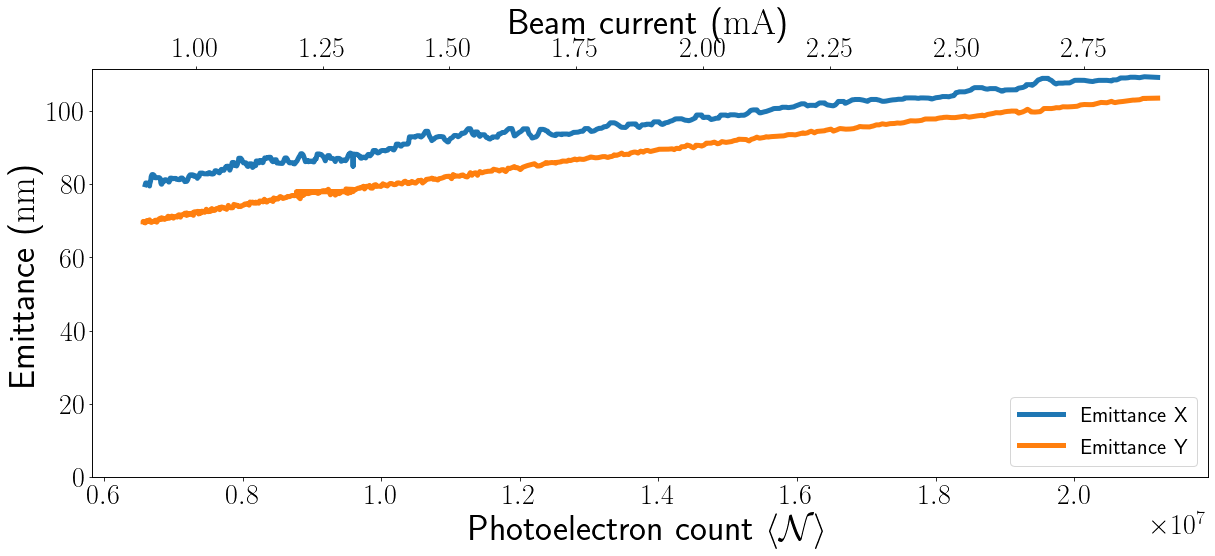

In [34]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel.rolling(10).max(), 1000*df['ex_um'].rolling(4).max(),'-', linewidth=5 , label='Emittance X')
ax.plot(photoel.rolling(4).max(), 1000*df['ey_um'],'-', linewidth=5 , label='Emittance Y')

ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [35]:
df.describe()

N:ITC1RSV   N:ITC1RSH   N:ITC2RSV   N:ITC2RSH   N:ITC3RSV   N:ITC3RSH  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean   403.461262  180.528329  162.781671  542.316104  244.150965  706.081110   
std     23.707386    9.519367    8.755053   22.051067   14.010200   31.051636   
min    366.855590  165.908400  148.873090  504.573000  221.775500  652.835020   
25%    383.640228  172.723653  155.551400  524.469510  232.512350  680.930785   
50%    399.376755  179.118300  160.677005  543.372495  241.202410  707.143980   
75%    422.930858  188.138055  170.080730  558.056243  255.747875  729.796248   
max    450.873900  199.830990  180.712910  586.966000  272.539400  767.367000   

          N:ITC4RSV     N:ITC4RSH   N:ITC4LSV   N:ITC4LSH   N:ITC3LSV  \
count  9.870000e+02  9.870000e+02  987.000000  987.000000  987.000000   
mean   1.059989e+02  7.327710e+02  484.644866  426.030443  240.326652   
std    2.843612e-14  2.274889e-13   23.366846   22.999321   15.599501   
min    1.059989e+02  7.327710e+02  447.181700  390.309390  215.425400   
25%    1.059989e+02  7.327710e+02  466.092345  407.097138  227.126050   
50%    1.059989e+02  7.327710e+02  482.578220  422.685000  236.921510   
75%    1.059989e+02  7.327710e+02  502.965990  444.571748  253.380950   
max    1.059989e+02  7.327710e+02  532.507020  472.266600  271.746090   

        N:ITC3LSH   N:ITC2LSV   N:ITC2LSH   N:ITC1LSV   N:ITC1LSH    N:IWCMBF  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean   724.659586  162.481969  580.702633  490.069649  186.341402   59.725896   
std     32.428560    9.057399   24.306647   30.771833    7.583646    2.934103   
min    669.916020  148.117490  538.787050  441.421600  173.213000   55.415281   
25%    698.465760  154.843150  560.720000  463.771590  180.145978   57.737712   
50%    725.128970  160.686490  581.862975  484.313720  186.685000   58.859168   
75%    749.612762  170.001328  598.602505  515.850755  192.018600   61.576582   
max    789.518980  180.630310  629.398010  551.085020  201.752900   85.897266   

         N:IWCMBR    N:IWCMBP     N:IWCMI    N:IRFEPA    N:IRFEPP    N:IWCMBE  \
count  987.000000  987.000000  987.000000  987.000000  987.000000  987.000000   
mean    28.302970  -84.065073   -1.828817  358.109946  102.203770   26.034175   
std      1.261724    0.152415    0.627901    0.443291    0.212149    1.296732   
min     26.389055  -84.407471   -3.273680  357.331375  101.603400   24.067336   
25%     27.224252  -84.188351   -2.294313  357.751159  102.047164   24.961900   
50%     28.095423  -84.088958   -1.677502  358.015227  102.245310   25.781221   
75%     29.298729  -83.957697   -1.291089  358.447725  102.380875   27.011241   
max     36.036870  -83.539501   -1.010110  359.146974  102.609346   33.941221   

         N:IWCMBM    N:IWCMBG    N:IWCMIG    N:IBEAMA  N:IRFEPC      N:IRFEAT  \
count  987.000000  987.000000  987.000000  987.000000     987.0  9.870000e+02   
mean    21.504921   25.260420   -1.800558   -1.678803      42.5 -8.800000e+00   
std      1.051213    1.283536    0.617301    0.565007       0.0  1.777257e-15   
min     19.947252   23.353572   -3.222574   -2.957565      42.5 -8.800000e+00   
25%     20.627302   24.292340   -2.256558   -2.099123      42.5 -8.800000e+00   
50%     21.291750   24.927869   -1.649184   -1.552415      42.5 -8.800000e+00   
75%     22.310263   26.146245   -1.272656   -1.189000      42.5 -8.800000e+00   
max     28.565972   35.545480   -0.996127   -0.936343      42.5 -8.800000e+00   

         N:IRFEFP    N:IRFECG  N:IWCMI_recalibrated_to_IWCMI_absolute  \
count  987.000000  987.000000                              987.000000   
mean     8.450570    0.260006                               -1.617707   
std      0.023353    0.000373                                0.555419   
min      8.411918    0.259419                               -2.895780   
25%      8.430000    0.259700                               -2.02

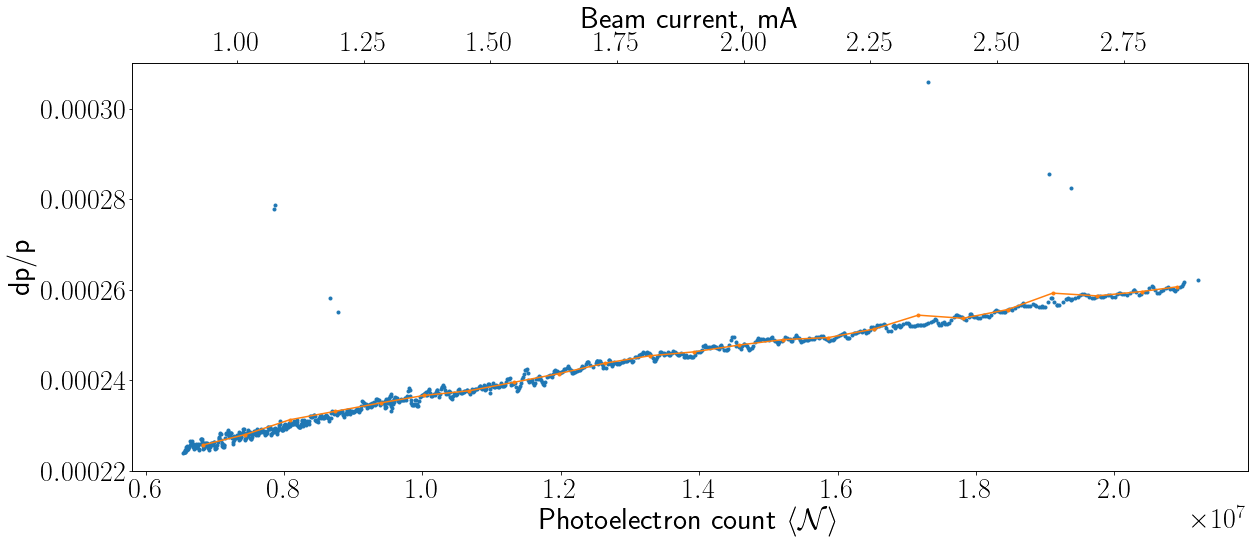

In [36]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['dp/p'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("dp/p")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['dp/p'] = df['dp/p']
dpp_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['dp/p'], bounds_error=False, fill_value="extrapolate")
dpp_interp = dpp_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
dpp_err_stat = np.std(first_injection['dp/p'].values-ey_interp)
ax.plot(photoel, df['dp/p'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [37]:
df_to_save = df_to_save.sort_values(by='N', ignore_index=True)
df_to_save

N  Sigma_um_X  Sigma_um_Y          sz_um     ex_um     ey_um  \
0   6.822991e+06  465.800456  263.442764  242511.737997  0.080929  0.070522   
1   7.442278e+06  470.868009  267.426168  245762.678713  0.082730  0.072671   
2   8.084032e+06  478.592273  271.339028  248504.548094  0.085552  0.074813   
3   8.735400e+06  481.047035  275.166796  251154.912227  0.086293  0.076938   
4   9.403211e+06  483.627377  277.247745  254092.589367  0.087076  0.078106   
5   1.002937e+07  489.576981  280.272400  255659.777833  0.089532  0.079819   
6   1.067964e+07  496.408777  282.855439  256853.526855  0.092593  0.081298   
7   1.132367e+07  498.631796  285.740379  259136.564602  0.093230  0.082964   
8   1.196957e+07  500.781086  288.636649  261665.115601  0.093824  0.084655   
9   1.263610e+07  502.086303  291.593880  264075.816348  0.093905  0.086398   
10  1.328790e+07  506.639963  294.006639  266109.165007  0.095754  0.087833   
11  1.392891e+07  509.015864  296.449522  267428.707311  0.096725  0.089299   
12  1.457567e+07  512.324227  298.945849  269478.414616  0.098011  0.090809   
13  1.521663e+07  515.787542  301.317027  270264.790317  0.099458  0.092255   
14  1.586307e+07  519.502552  303.465820  271728.519690  0.101237  0.093576   
15  1.652001e+07  522.223232  305.684828  273968.092319  0.102159  0.094949   
16  1.716548e+07  525.521573  308.203108  275365.422311  0.103032  0.096525   
17  1.781322e+07  526.320241  310.102005  277255.934062  0.103658  0.097713   
18  1.846028e+07  531.171583  311.574674  278840.269354  0.105680  0.098643   
19  1.910923e+07  535.037114  313.914065  280931.429940  0.106749  0.100133   
20  1.974959e+07  536.624844  315.353176  282580.417115  0.107760  0.101050   
21  2.039800e+07  538.651473  317.291372  284077.228085  0.108579  0.102296   
22  2.091223e+07  540.267132  318.802389  285360.622244  0.109159  0.103273   

        dp/p  
0   0.000226  
1   0.000228  
2   0.000231  
3   0.000233  
4   0.000235  
5   0.000237  
6   0.000238  
7   0.000240  
8   0.000241  
9   0.000244  
10  0.000245  
11  0.000246  
12  0.000248  
13  0.000249  
14  0.000249  
15  0.000251  
16  0.000254  
17  0.000254  
18  0.000256  
19  0.000259  
20  0.000259  
21  0.000260  
22  0.000261

In [38]:
df_to_save.to_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))

In [39]:
first_injection.to_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [40]:
first_injection

N:ITC1RSV   N:ITC1RSH   N:ITC2RSV   N:ITC2RSH  \
2020-03-16 13:48:46  450.873900  199.830990  180.712910  586.695980   
2020-03-16 13:48:47  450.754895  199.788245  180.648105  586.667995   
2020-03-16 13:48:48  450.635890  199.745500  180.583300  586.640010   
2020-03-16 13:48:49  450.484405  199.664895  180.457355  586.803005   
2020-03-16 13:48:50  450.332920  199.584290  180.331410  586.966000   
...                         ...         ...         ...         ...   
2020-03-16 14:05:08  367.083800  166.341890  149.685810  508.833010   
2020-03-16 14:05:09  367.718305  166.176745  150.042255  506.978500   
2020-03-16 14:05:10  368.352810  166.011600  150.398700  505.123990   
2020-03-16 14:05:11  368.234710  166.044155  150.230950  504.848495   
2020-03-16 14:05:12  368.116610  166.076710  150.063200  504.573000   

                      N:ITC3RSV   N:ITC3RSH  N:ITC4RSV  N:ITC4RSH   N:ITC4LSV  \
2020-03-16 13:48:46  272.539400  767.182010   105.9989    732.771  532.507020   
2020-03-16 13:48:47  272.397995  767.200015   105.9989    732.771  532.448515   
2020-03-16 13:48:48  272.256590  767.218020   105.9989    732.771  532.390010   
2020-03-16 13:48:49  272.117095  767.292510   105.9989    732.771  532.181515   
2020-03-16 13:48:50  271.977600  767.367000   105.9989    732.771  531.973020   
...                         ...         ...        ...        ...         ...   
2020-03-16 14:05:08  223.206190  658.341000   105.9989    732.771  449.975590   
2020-03-16 14:05:09  223.579140  656.404480   105.9989    732.771  449.332890   
2020-03-16 14:05:10  223.952090  654.467960   105.9989    732.771  448.690190   
2020-03-16 14:05:11  223.619700  655.029480   105.9989    732.771  447.935945   
2020-03-16 14:05:12  223.287310  655.591000   105.9989    732.771  447.181700   

                      N:ITC4LSH   N:ITC3LSV   N:ITC3LSH   N:ITC2LSV  \
2020-03-16 13:48:46  472.266600  271.746090  789.077030  180.630310   
2020-03-16 13:48:47  472.129350  271.538190  789.298005  180.566355   
2020-03-16 13:48:48  471.992100  271.330290  789.518980  180.502400   
2020-03-16 13:48:49  471.885500  271.318695  789.234985  180.447350   
2020-03-16 13:48:50  471.778900  271.307100  788.950990  180.392300   
...                         ...         ...         ...         ...   
2020-03-16 14:05:08  390.401090  216.642790  676.034000  148.813800   
2020-03-16 14:05:09  390.728790  217.218495  673.971530  149.039200   
2020-03-16 14:05:10  391.056490  217.794200  671.909060  149.264600   
2020-03-16 14:05:11  391.313445  217.743955  671.966035  149.282150   
2020-03-16 14:05:12  391.570400  217.693710  672.023010  149.299700   

                      N:ITC2LSH   N:ITC1LSV   N:ITC1LSH   N:IWCMBF   N:IWCMBR  \
2020-03-16 13:48:46  629.398010  551.085020  201.661100  65.611069  30.869360   
2020-03-16 13:48:47  629.325990  550.726500  201.707000  75.153669  33.265594   
2020-03-16 13:48:48  629.253970  550.367980  201.752900  85.897266  36.036870   
2020-03-16 13:48:49  629.196990  550.444490  201.625900  76.245254  33.635192   
2020-03-16 13:48:50  629.140010  550.521000  201.498900  65.337742  30.830237   
...                         ...         ...         ...        ...        ...   
2020-03-16 14:05:08  544.280030  443.441410  174.888210  55.666149  26.400883   
2020-03-16 14:05:09  542.638030  444.026155  174.469405  55.666149  26.400883   
2020-03-16 14:05:10  540.996030  444.610900  174.050600  55.666149  26.400883   
2020-03-16 14:05:11  539.929505  445.042540  173.631800  55.608524  26.412014   
2020-03-16 14:05:12  538.862980  445.474180  173.213000  55.713399  26.389055   

                      N:IWCMBP   N:IWCMI    N:IRFEPA    N:IRFEPP   N:IWCMBE  \
2020-03-16 13:48:46 -83.746559 -3.273680  359.093230  101.736840  28.638256   
2020-03-16 13:48:47 -83.653120 -2.991135  359.086791  101.710797  31.126353   
2020-03-16 13:48:48 -83.539501 -2.672711  359.010496  101.675489  33.941221   
2020-03-16 13:48:49 -83.670001 -2.941951  358.915880  